lda topic to 3, no bigrams or trigrams, hyperparameters and coherence

 **Project: Using NLP for Requirements Engineering for Data management Software**
 
Azure Data Factory 2Query: Fine tuning the data set


**Query**

SELECT
    q.Id AS QuestionId,
    q.Title AS QuestionTitle,
    q.Body AS QuestionBody,
    q.Tags AS QuestionTags,
    q.CreationDate AS Date,
    q.ViewCount AS ViewCount,
    q.Score AS Score,
    q.AnswerCount AS NumberOfAnswers,
    a.Id AS AnswerId,
    a.Body AS AnswerBody
FROM 
    Posts q
INNER JOIN 
    Posts a ON a.ParentId = q.Id
WHERE 
    q.PostTypeId = 1
    AND (
        q.Tags LIKE '%<azure-data-factory>%'
        OR q.Tags LIKE '%<adf>%'
        OR q.Title Like '%<azure data factory>%'
        OR q.Title Like '%<adf>%'
    )
    AND q.CreationDate >= '2018-01-01'
    AND q.CreationDate <= '2023-05-03'
ORDER BY 
    q.CreationDate DESC 

**Tags**

azure-data-factory

adf

**Title** 

azure data factory

adf

In [1]:
#!pip install ipython
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.rendered_html { max-height: 500px; overflow-y: scroll !important; }</style>"))

In [2]:
import pandas as pd

# Load the datasets into pandas DataFrames
df = pd.read_csv('adf_query_lemmatized.csv')

In [3]:
len(df)

8547

tags: pipeline, dataflow

title: mapping, data flow, data flow, flow, pipeline

text: dataflow, data flow, flow, pipeline, following, mapping

In [4]:
import datetime
# Convert the 'Date' column to a datetime object to allow for better manipulation:
df['Date'] = pd.to_datetime(df['Date'])

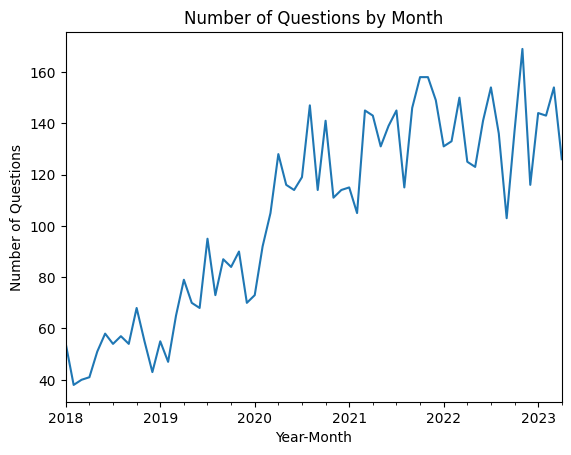

In [5]:
import matplotlib.pyplot as plt
# Analyze the distribution of questions over time:

df['YearMonth'] = df['Date'].dt.to_period('M')

question_count_by_month = df.groupby('YearMonth')['QuestionId'].nunique()
question_count_by_month.plot()
plt.xlabel('Year-Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions by Month')
plt.show()

In [6]:
# Create a sub-set of data which excludes rows where the creation date is before February 2020. 
# The graph above shows a drastic increase of questions regarding Azure Data Factory around the 
# beginning of the corona virus pandemic in February 2020.

# Create new column CreationDate to allow filtering
df['CreationDate'] = pd.to_datetime(df['Date'])
start_date = pd.to_datetime('2020-02-01')

# Filter by relevant keywords identified in previous queries
title_keywords = ['mapping', 'data flow', 'dataflow', 'flow', 'pipeline']
body_keywords = ['dataflow', 'data flow', 'flow', 'pipeline', 'following', 'mapping']
tags_keywords = ['pipeline', 'dataflow']

# Create new data frame with date and keyword filters
create_new_df = df[((df['QuestionTitle'].str.contains('|'.join(title_keywords), case=False)) |
                 (df['QuestionBody'].str.contains('|'.join(body_keywords), case=False)) |
                 (df['QuestionTags'].str.contains('|'.join(tags_keywords), case=False))) &
                 (df['CreationDate'] >= start_date)]

In [7]:
len(create_new_df)

4035

In [8]:
df2 = create_new_df.copy()

In [9]:
# Check if data filter was applied correctly

if df2[df2['CreationDate'] < '2020-02-01'].shape[0] > 0:
    print("There are rows in df2 with CreationDate earlier than 2020-02-01")
else:
    print("All rows in df2 have CreationDate after or equal to 2020-02-01")

All rows in df2 have CreationDate after or equal to 2020-02-01


**Initial Data Exploration**

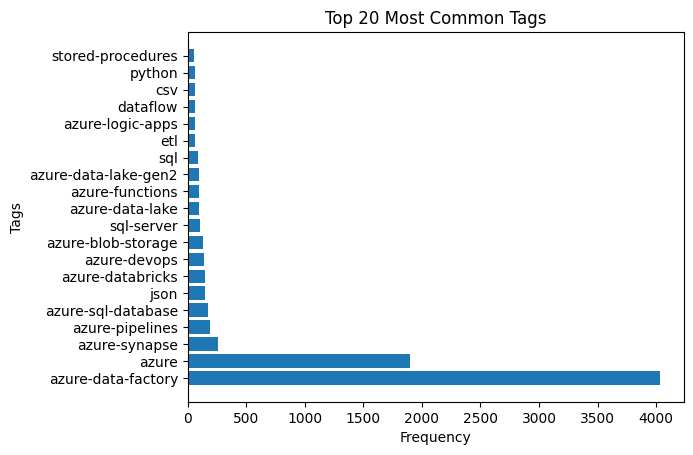

In [10]:
# Analyze the most common tags:
from collections import Counter

import seaborn as sns
tags = df2['QuestionTags'].str.findall('<(.*?)>').explode().values
tag_counts = Counter(tags)
most_common_tags = tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_tags], [count for _, count in most_common_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Tags')
plt.show()

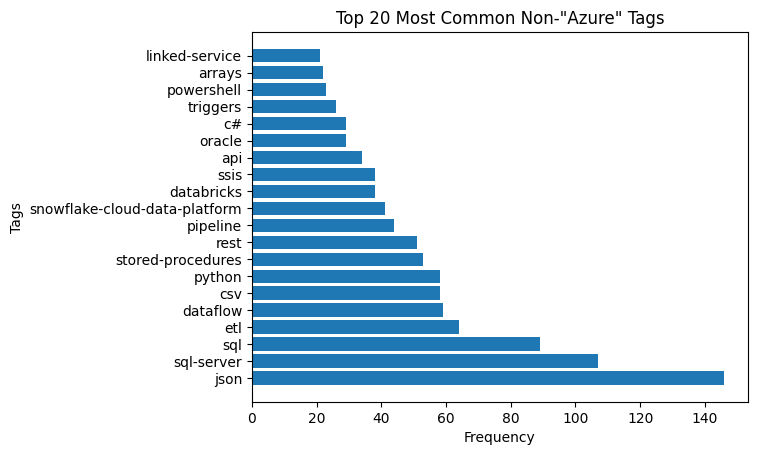

In [11]:
# Analyze the moct common tags which to don contain the keyword "Azure"

# Find and extract tags
df2['SplitTags'] = df2['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df2.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 20 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Non-"Azure" Tags')
plt.show()

#This code filters out empty tags as well as tags containing "azure". 

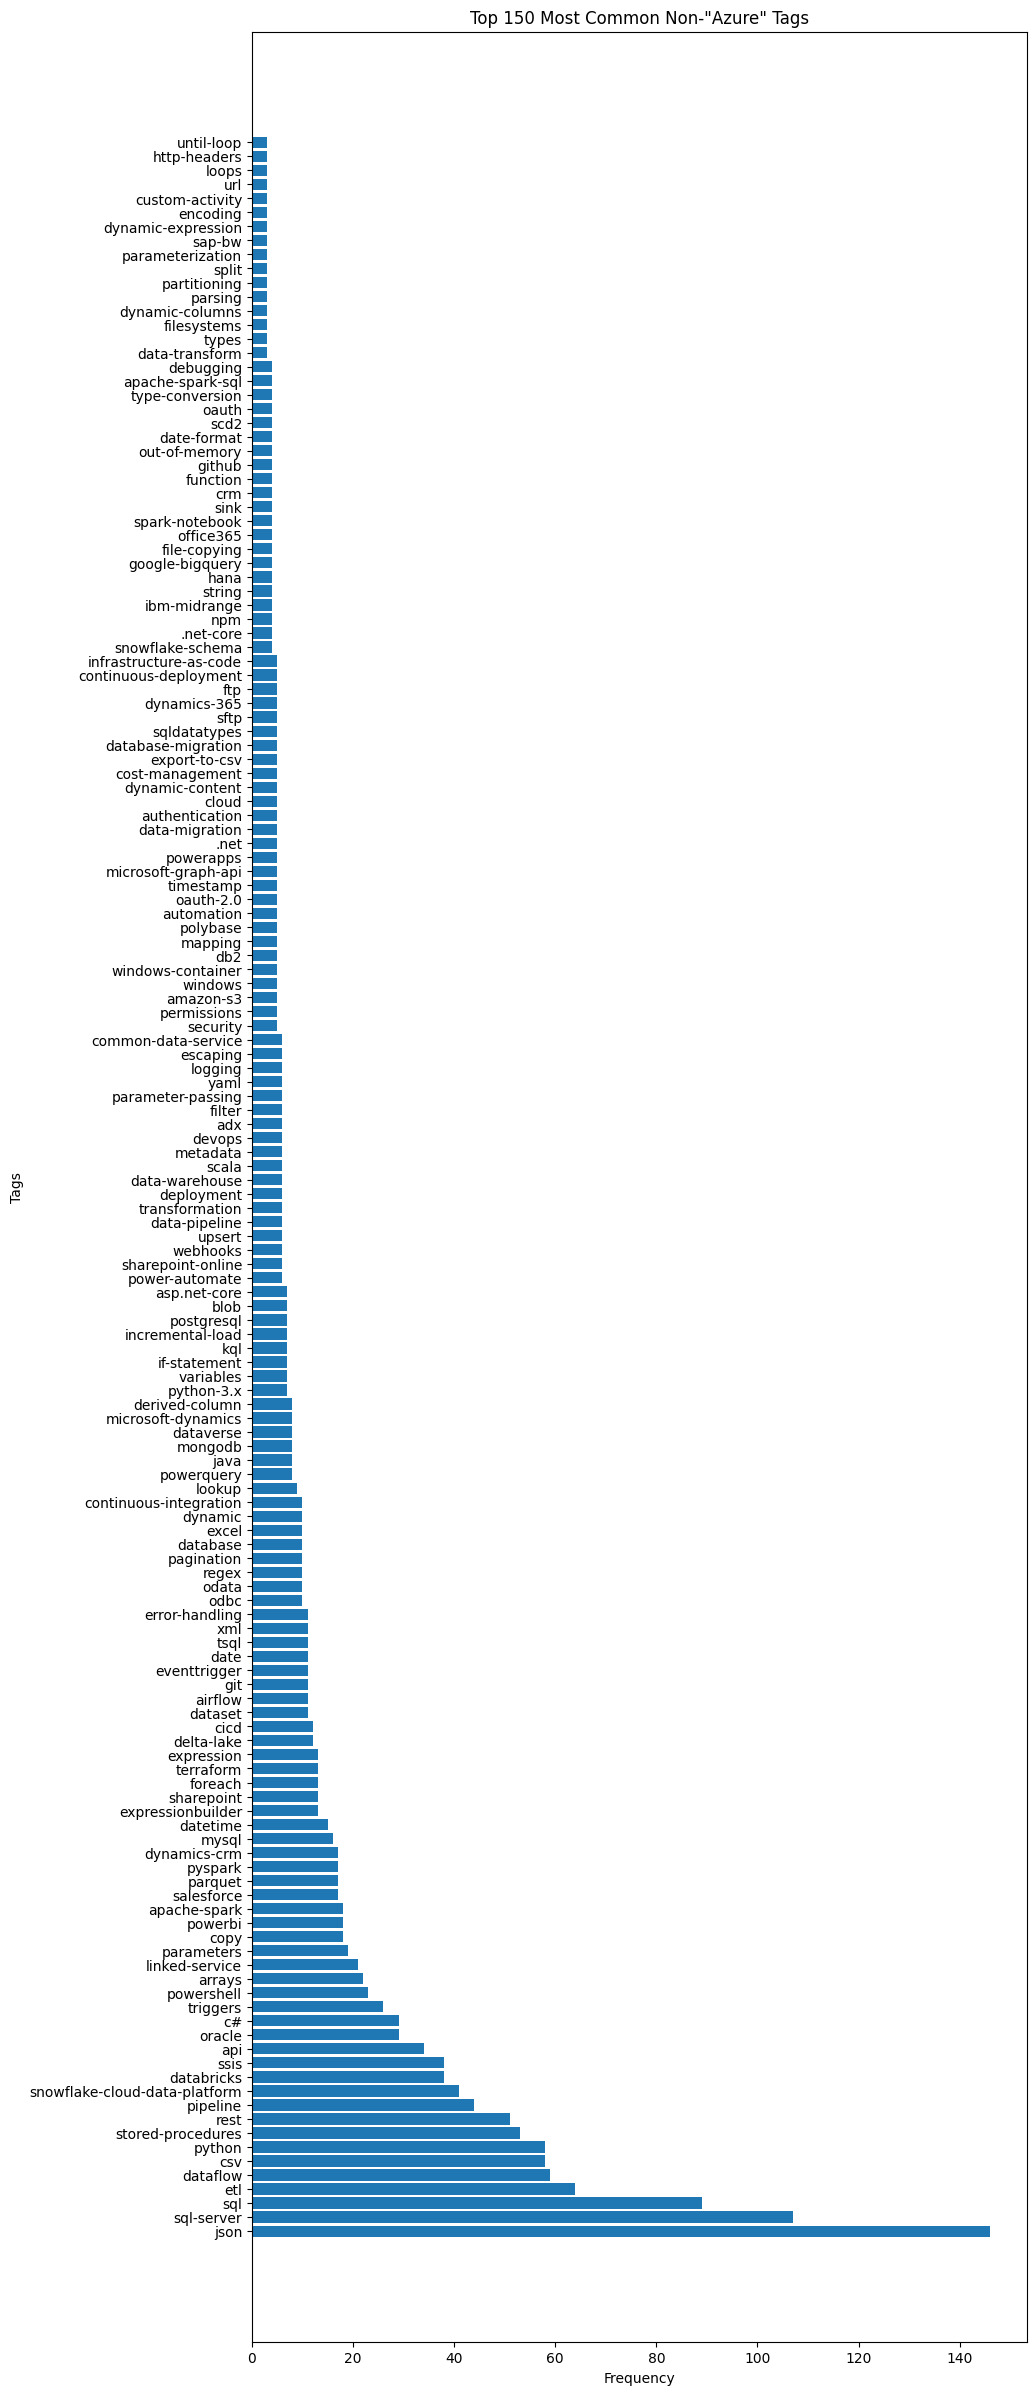

List of the top 150 non-'Azure' tags:
['json', 'sql-server', 'sql', 'etl', 'dataflow', 'csv', 'python', 'stored-procedures', 'rest', 'pipeline', 'snowflake-cloud-data-platform', 'databricks', 'ssis', 'api', 'oracle', 'c#', 'triggers', 'powershell', 'arrays', 'linked-service', 'parameters', 'copy', 'powerbi', 'apache-spark', 'salesforce', 'parquet', 'pyspark', 'dynamics-crm', 'mysql', 'datetime', 'expressionbuilder', 'sharepoint', 'foreach', 'terraform', 'expression', 'delta-lake', 'cicd', 'dataset', 'airflow', 'git', 'eventtrigger', 'date', 'tsql', 'xml', 'error-handling', 'odbc', 'odata', 'regex', 'pagination', 'database', 'excel', 'dynamic', 'continuous-integration', 'lookup', 'powerquery', 'java', 'mongodb', 'dataverse', 'microsoft-dynamics', 'derived-column', 'python-3.x', 'variables', 'if-statement', 'kql', 'incremental-load', 'postgresql', 'blob', 'asp.net-core', 'power-automate', 'sharepoint-online', 'webhooks', 'upsert', 'data-pipeline', 'transformation', 'deployment', 'data-wa

In [12]:
# Show the Top 150 non-Azure keywords

# Find and extract tags
df2['SplitTags'] = df2['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df2.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 150 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(150)

plt.figure(figsize=(10, 30))  # Adjust the plot size for better visibility
plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 150 Most Common Non-"Azure" Tags')
plt.show()

# Print the list of the top 150 non-"azure" tags
top_150_tags = [tag for tag, _ in most_common_non_azure_tags]
print("List of the top 150 non-'Azure' tags:")
print(top_150_tags)

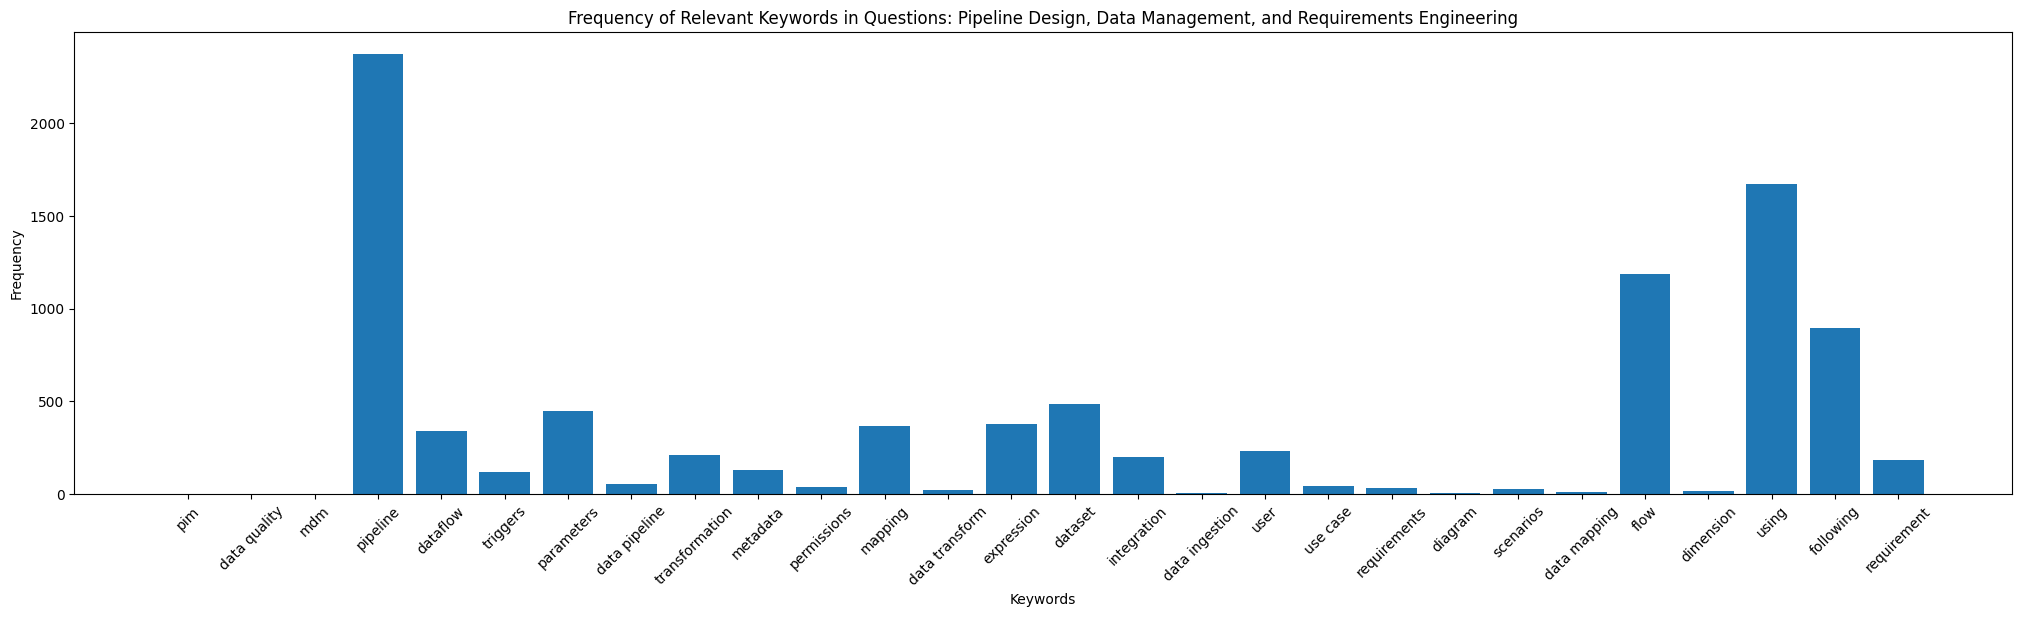

In [13]:
# Check for relevant keywords relating to requirements engineering, pipeline design, 
# data management or product data management. Keywords were deived from this and
# from previous queries

keywords_to_plot = ['pim', 'data quality', 'data governance', 'mdm','master data mangement', 'pipeline', 'dataflow', 'triggers', 'parameters', 'eventtrigger', 'data pipeline', 
                    'transformation', 'metadata', 'permissions', 'mapping',
                    'database-migration', 'database migration','snowflake-schema', 'snowflake schema', 'data transform',
                    'data-transform', 'networking', 'expression', 'dataset', 'integration', 'data-ingestion', 'data ingestion', 
                    'user', 'use case', 'system-requirements', 'system requirements', 
                    'use-case-diagram', 'use case diagram', 'requirements', 'modeling', 'diagram', 'scenarios', 
                    'data-synchronization', 'data synchronization', 'data-mapping', 
                    'data mapping', 'dataflow-diagram', 'dataflow diagram', 
                    'master-data-management', 'master data management', 'product-data-management', 'product data management' 
                    'product-data', 'product data', 'data-modelling', 'data modelling', 'dimensional-modelling', 
                    'dimensional modelling', 'star-schema', 'star schema' 'data-quality',
                    'business-intelligence', 'data-transformation', 'data transformation' 'actor', 'system-requirements', 
                    'system requirements', 'flow', 'dimension', 'using', 'following', 'requirement']

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df2['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df2['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Set the figure size (width, height)
plt.figure(figsize=(25, 6))

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Relevant Keywords in Questions: Pipeline Design, Data Management, and Requirements Engineering')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Results**

The manually defined keywords in df2 can be interpreted as follows: 

The data set seems to center around data management in Azure Data Factory in general. Requirements engineering for data piplines is represented by keywords such as "user", "use case", "using", "actor". Data management is presented by keywords such as "flow", "dataflow", "data flow", "dimension", "data integration", "data mapping", "mapping", "etl". Data governance and data quality is represented by the verb "following". There is no significant mentioning of terms such as pim or mdm.

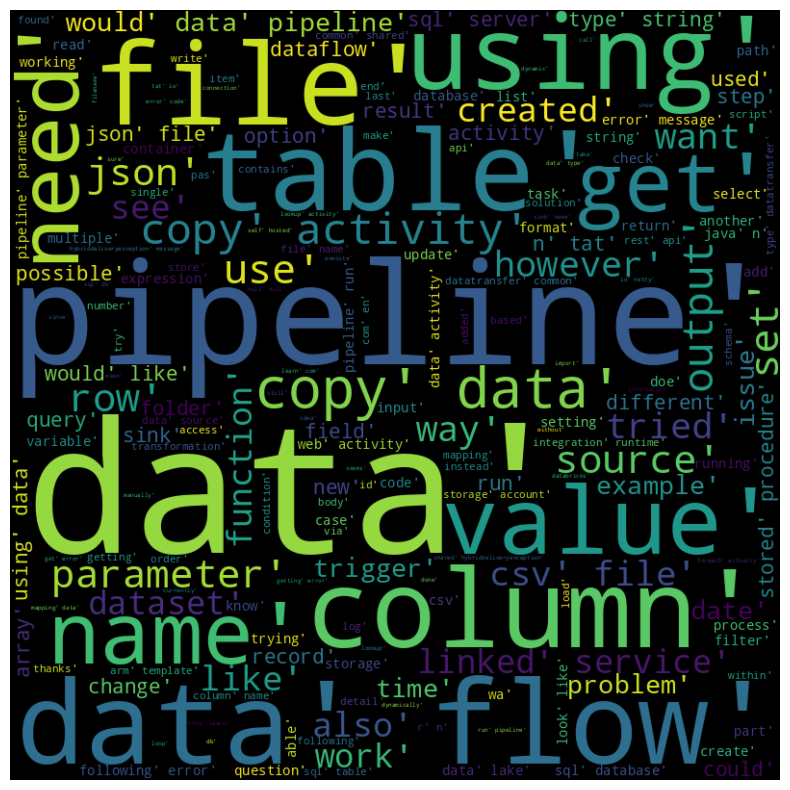

In [14]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define stop_words and stop_phrases separately
stop_words = {'adf', 'azure', 'ha', 'microsoft', 'blob', 'factory', 'one', 'two', 
              'first', 'second', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u'
             }
stop_phrases = {'azure data', 'data factory', 'u u', 'azure data factory', 'azure pipeline', 'azure synapse', 
                  'azure sql database', 'azure data lake', 'azure blob storage', 'azure databricks', 'azure devops'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# Combine all the preprocessed texts into a single string
preprocessed_texts = ' '.join(df2['LemmatizedQuestionBody'].astype(str))

# Remove stop words and stop phrases from the preprocessed_texts
for stopword in all_stop_words:
    preprocessed_texts = re.sub(r'\b' + re.escape(stopword) + r'\b', '', preprocessed_texts, flags=re.IGNORECASE)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800)

# Generate the word cloud with a larger size (e.g., 800x800) and the preprocessed_texts without stopwords
cloud = wordcloud.generate(preprocessed_texts.lower())

# Display the word cloud
plt.figure(figsize=(10, 10))  # Increase the figure size for better visibility
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Extractions with spaCy**


In [15]:
from collections import defaultdict
import spacy
import re

# Define stop words and stop phrases
stop_words = {'microsoft', 'factory', 'one', 'u u', 'two', 
              'first', 'second', 'azure', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 'azure data', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u', 
              'europe', 'ec', 'tenant_id', 'thousand', 'yesterday',
              'adl', 'jan', 'monthly', 'to_date', 'subscription_id', 'created'
             }
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs
entities_counter = defaultdict(int)
nouns_counter = defaultdict(int)
verbs_counter = defaultdict(int)

for _, row in df2.iterrows():
    question_body = row['LemmatizedQuestionBody']
    
    # Remove stop words and stop phrases from the question_body
    for stopword in all_stop_words:
        question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
    
    doc = nlp(question_body)
        
    for ent in doc.ents:
        if ent.text.lower() not in stop_words:
            entities_counter[ent.text.lower()] += 1
        
    for token in doc:
        if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
            nouns_counter[token.text.lower()] += 1
        elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
            verbs_counter[token.text.lower()] += 1

# Display the top 10 most common entities, nouns, and verbs
def display_top_n(counter, n, title):
    print(title)
    for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{item}: {count}")
    print()

display_top_n(entities_counter, 10, "Top 10 Entities")
display_top_n(nouns_counter, 10, "Top 10 Nouns")
display_top_n(verbs_counter, 10, "Top 10 Verbs")

Top 10 Entities
dominguez: 28
tom: 21
'quarter': 18
uk: 17
aml': 16
weekly: 15
bob: 15
friday: 13
michael: 12
workday: 12

Top 10 Nouns
data: 8608
pipeline: 5619
file: 4768
activity: 3678
type: 2956
error: 2849
name: 2819
source: 2736
column: 2703
table: 2697

Top 10 Verbs
using: 2542
get: 1979
run: 1543
want: 1439
need: 1403
following: 1128
set: 1119
trying: 1089
tried: 1019
create: 983



**Latent Dirichlet Allocation**

In [16]:
'''import ast
import random
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df2['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seeds for random number generators to ensure consistent results
random.seed(42)
LdaModel.seed = 42

# Hyperparameters to explore
num_topics_list = [3, 4, 5]  # Adjusted to generate three topics
alpha_list = ['auto', 'symmetric', 0.1, 0.5]
eta_list = ['auto', 'symmetric', 0.1, 0.5]
passes_list = [10, 15, 20]

best_coherence = -1
best_model = None
best_params = None

for num_topics in num_topics_list:
    for alpha in alpha_list:
        for eta in eta_list:
            for passes in passes_list:
                lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=eta)
                coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
                coherence = coherence_model.get_coherence()
                
                if coherence > best_coherence:
                    best_coherence = coherence
                    best_model = lda_model
                    best_params = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta, 'passes': passes}

print("Best coherence score:", best_coherence)
print("Best model parameters:", best_params)

# Display the top words for each topic of the best model
words_per_topic = 10  # Specify the number of top words per topic
for topic in range(best_params['num_topics']):
    print(f"Topic {topic + 1}:")
    top_words = best_model.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        print(f"  {word}: {weight:.4f}")
    print()'''

Best coherence score: 0.5624055906882698
Best model parameters: {'num_topics': 3, 'alpha': 0.5, 'eta': 'auto', 'passes': 10}
Topic 1:
  data: 0.0398
  file: 0.0330
  activity: 0.0287
  pipeline: 0.0250
  azure: 0.0206
  name: 0.0155
  copy: 0.0119
  error: 0.0113
  row: 0.0113
  factory: 0.0112

Topic 2:
  data: 0.0214
  type: 0.0149
  column: 0.0138
  error: 0.0123
  value: 0.0120
  source: 0.0104
  parameter: 0.0098
  azure: 0.0087
  json: 0.0085
  name: 0.0081

Topic 3:
  pipeline: 0.0320
  azure: 0.0244
  data: 0.0193
  run: 0.0172
  factory: 0.0145
  trigger: 0.0122
  table: 0.0104
  b: 0.0096
  want: 0.0079
  sql: 0.0065



In [43]:
# Visualize the LDA model using pyLDAvis
pyLDAvis.enable_notebook()

def custom_topic_names(topic_number):
    topic_names = {
        0: 'Topic1',
        1: 'Topic2',
        2: 'Topic3'
    }
    return topic_names.get(topic_number, '')

lda_viz = gensimvis.prepare(best_model, corpus, dictionary)

for i in range(best_params['num_topics']):
    lda_viz.topic_info.loc[lda_viz.topic_info.Category == f'Topic {i+1}', 'Category'] = custom_topic_names(i)
    lda_viz.topic_coordinates.loc[i, 'topics'] = custom_topic_names(i)

# Display the visualization
pyLDAvis.display(lda_viz)

In [17]:
# Check for total number of missing values
print(df2.isnull().sum().sum())

0


In [35]:
import numpy as np

# Define a function that safely evaluates literals
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return []

# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = best_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

# Define a function that returns the topic name based on the index
def get_topic_name(topic_index):
    topic_names = {
        0: 'Topic1',
        1: 'Topic2',
        2: 'Topic3'
    }
    return topic_names.get(topic_index, '')

# Apply safe_literal_eval and assign_topic functions to the 'LemmatizedQuestionBody' column
df2['LDATopic'] = df2['LemmatizedQuestionBody'].apply(lambda x: assign_topic(safe_literal_eval(x)))

# Assign topic names to a new column 'LDATopicName'
df2['LDATopicName'] = df2['LDATopic'].apply(get_topic_name)

# Check for total number of missing values
print(df2.isnull().sum().sum())

0


In [36]:
# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = best_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

df2['LDATopic'] = df2['LemmatizedQuestionBody'].apply(lambda x: assign_topic(ast.literal_eval(x)))

In [20]:
#df2.to_csv('df2_backup_11may.csv', index=True)

In [24]:
# Load the datasets into pandas DataFrames
#df3 = pd.read_csv('df2_backup_11may.csv')

In [ ]:
!!!!!LDATopic: fill all values with 11 which are not 0 or 1

In [ ]:
!!!!!LDATopicName: fill all values wit "No Topic Assigned" if not name of topic 1 or topic two 

In [37]:
topic_distribution = df3['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
1    2605
2     813
0     617
Name: count, dtype: int64


In [27]:
#df3.loc[(df3['LDATopic'].astype(str) != '0') & (df3['LDATopic'].astype(str) != '1') & (df3['LDATopic'].astype(str) != '2'), 'LDATopic'] = '11'

In [29]:
# df3.loc[df3['LDATopic'] == '11', 'LDATopicName'] = 'No Topic Assigned'

In [38]:
topic_distribution = df3['LDATopicName'].value_counts()
print(topic_distribution)

LDATopicName
Topic2    2605
Topic3     813
Topic1     617
Name: count, dtype: int64


In [39]:
# For the VADER Sentiment Analyzer it is reccommendet to use raw, unproecessed text the way it coems out of socail media.

import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply the function to the 'AnswerBody' column and store the sentiment scores in a new column
df3['VaderSentimentScores'] = df3['QuestionBody'].apply(get_sentiment_score)

# Calculate the average sentiment score for each topic
avg_sentiment_by_topic = df3.groupby('LDATopicName')['VaderSentimentScores'].apply(lambda scores: pd.DataFrame(scores.tolist()).mean())

print(avg_sentiment_by_topic)

# Note: The VADER sentiment analyzer is designed for social media texts and might not be the best choice 
# for your specific dataset. If you find that the sentiment analysis results are not accurate enough, 
# you can consider using other sentiment analysis libraries or training your own sentiment analysis model 
# using machine learning techniques.
#
# Some alternative sentiment analysis libraries include TextBlob and spaCy. You can also explore using
# pre-trained models for sentiment analysis from popular NLP libraries like Hugging Face's Transformers.

# This code will apply the VADER sentiment analyzer to each answer in the DataFrame, store the sentiment 
# scores in a new column called SentimentScores, and calculate the average sentiment score for each topic. 
# The limitations and suggestions for alternative approaches are provided as comments within the code.


LDATopicName          
Topic1        neg         0.025078
              neu         0.915848
              pos         0.059091
              compound    0.278134
Topic2        neg         0.034479
              neu         0.904119
              pos         0.061401
              compound    0.222670
Topic3        neg         0.026114
              neu         0.916776
              pos         0.057100
              compound    0.245414
Name: VaderSentimentScores, dtype: float64


The topics have a neutral sentiment while the compound scores are positive with exceptions in "Data Type and Microsoft Error Handling" and "Errors and Troubleshooting". The latter have negative compound scores of -0.2398 and -0.2470, respectively.

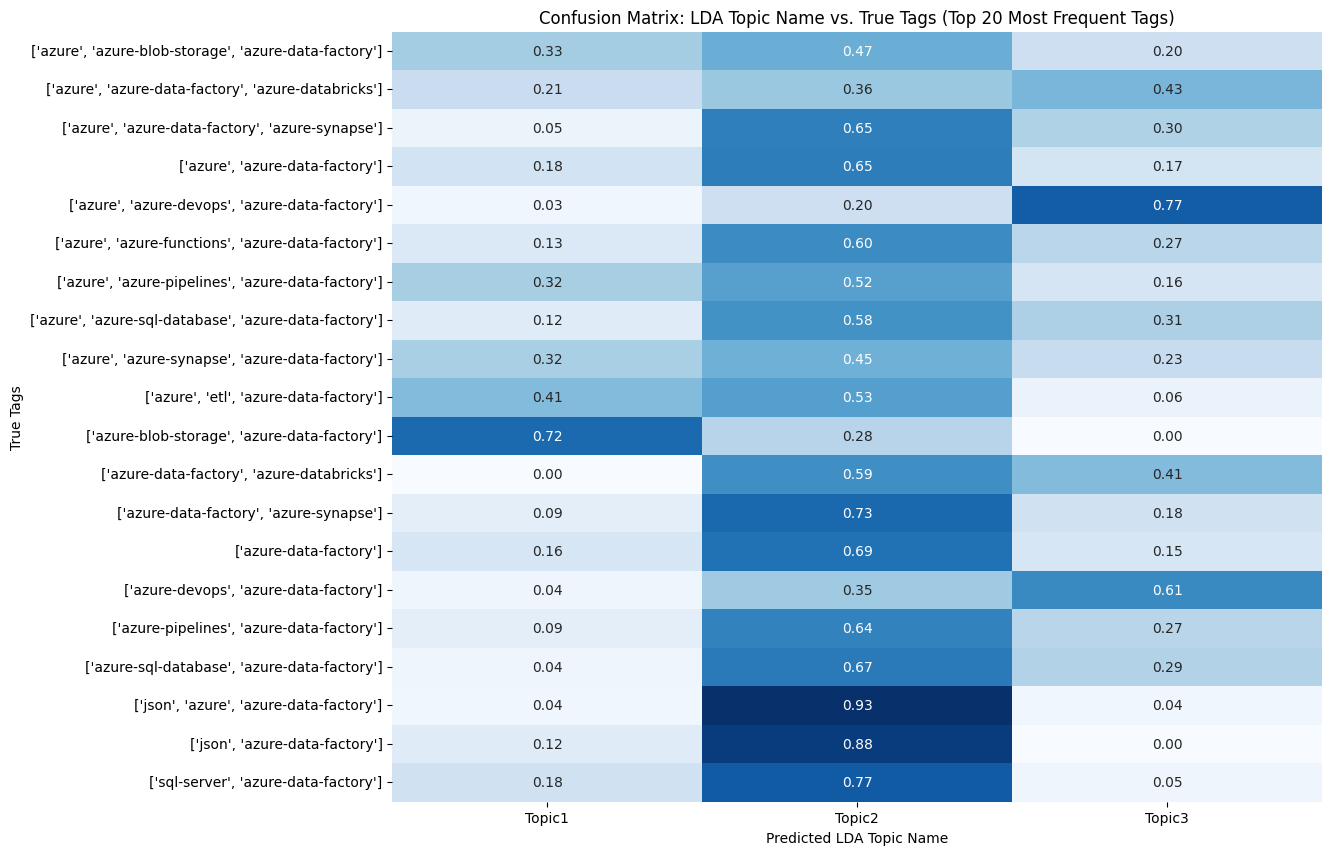

In [44]:
df3_top_n_tags = 20

# Get the top N most frequent tags
df3_top_tags = df3['Tags'].value_counts().nlargest(df3_top_n_tags).index.tolist()

# Filter the dataset
df3_filtered_df3 = df3[df3['Tags'].isin(df3_top_tags)]

# Create a confusion matrix
confusion_matrix = pd.crosstab(df3_filtered_df3['Tags'], df3_filtered_df3['LDATopicName'])

# Normalize the confusion matrix by row to show proportions
df3_normalized_confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)


plt.figure(figsize=(12, 10))
sns.heatmap(df3_normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)

plt.xlabel('Predicted LDA Topic Name')
plt.ylabel('True Tags')
plt.title('Confusion Matrix: LDA Topic Name vs. True Tags (Top {} Most Frequent Tags)'.format(df3_top_n_tags))
plt.show()

# This heatmap provides insights into the relationship between the true tags and the LDA topic 
# names, helping to evaluate the performance of the LDA model in terms of topic extraction. 
# Ideally, if the LDA model is performing well, there should be a strong diagonal pattern in 
# the heatmap, indicating that most true tags correspond to the predicted LDA topic names.

C:\Users\TanjaWolf_7ms6v6m\AppData\Local\Temp\ipykernel_13056\2500652168.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_filtered.loc[:, 'KeywordStrength'] = df3_filtered.apply(lambda row: compute_keyword_strength(row, keywords), axis=1)


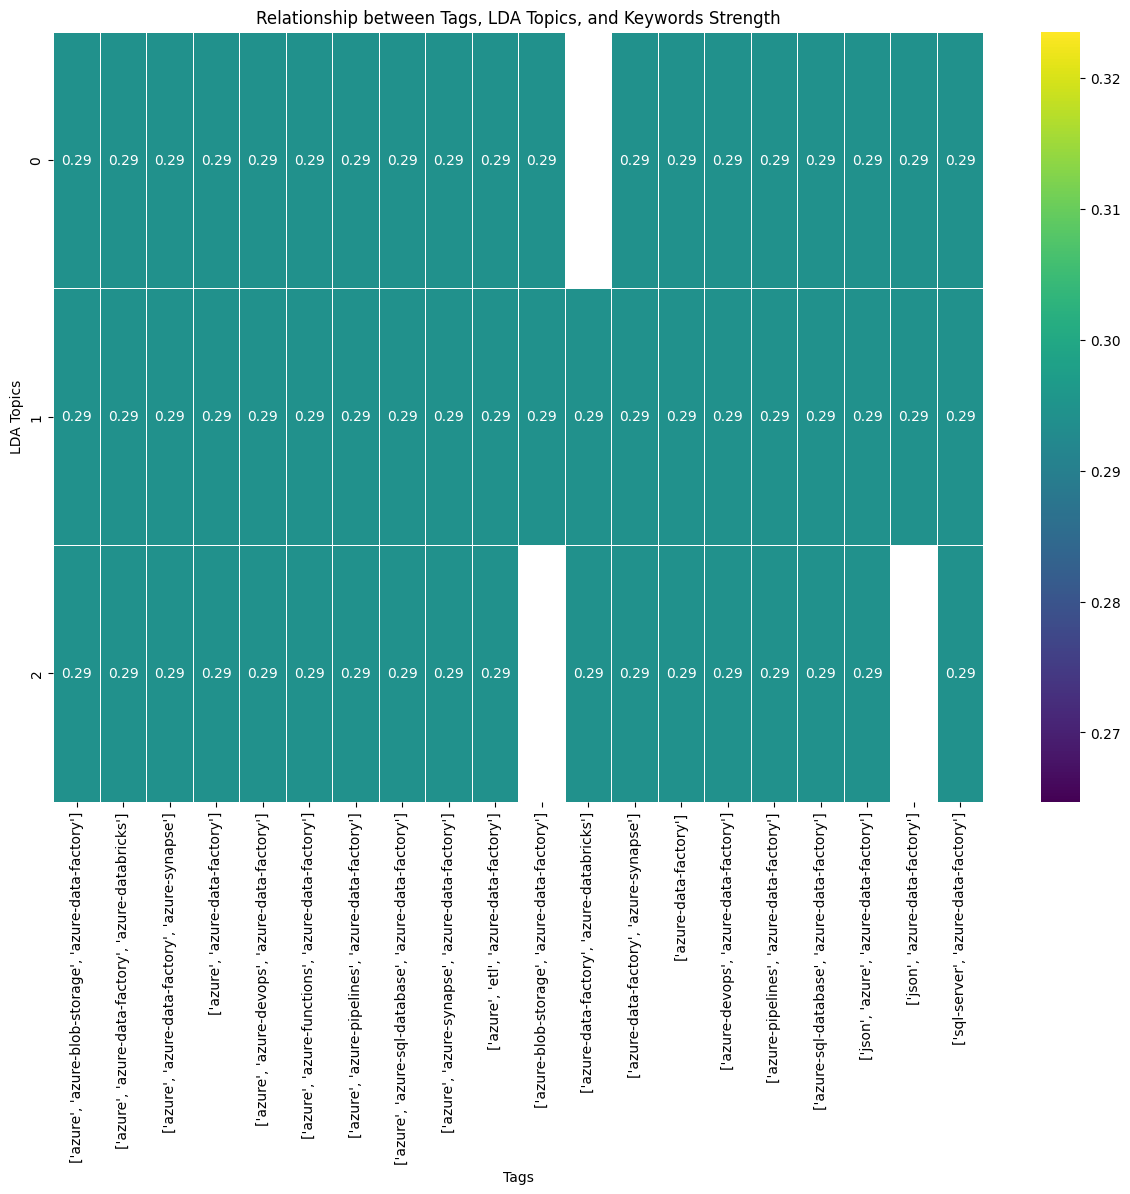

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel
import ast

def extract_keywords(text, keywords, n_keywords=5):
    words = text.split()
    keyword_count = {keyword: words.count(keyword) for keyword in keywords}
    sorted_keywords = sorted(keyword_count, key=keyword_count.get, reverse=True)
    return sorted_keywords[:n_keywords]

def compute_keyword_strength(row, keywords):
    extracted_keywords = extract_keywords(row['QuestionBody'], keywords)
    keyword_strength = len(extracted_keywords) / len(keywords)
    return keyword_strength

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df3['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model. You can choose the number of topics by setting the num_topics parameter:
num_topics = 2# Change this value to the desired number of topics
best_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
#for topic in range(num_topics):
   # print(f"Topic {topic + 1}:")
    #top_words = lda_model1.show_topic(topic, topn=words_per_topic)
    #for word, weight in top_words:
        #print(f"  {word}: {weight:.4f}")
    #print()

# Extract the top keywords from the LDA topics
keywords = set()
for topic in range(num_topics):
    top_words = best_model.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        keywords.add(word)

# Filter the data to only include the top tags and topics
top_n_tags = 20
top_n_topics = 10
top_tags = df3['Tags'].value_counts().nlargest(top_n_tags).index.tolist()
df3_filtered = df3[(df3['Tags'].isin(top_tags)) & (df3['LDATopic'] < top_n_topics)]

# Compute keyword strength for each data point
df3_filtered.loc[:, 'KeywordStrength'] = df3_filtered.apply(lambda row: compute_keyword_strength(row, keywords), axis=1)

# Create a pivot table with tags on the x-axis, topics on the y-axis, and mean keyword strength as the cell value
pivot_table = df3_filtered.pivot_table(index='LDATopic', columns='Tags', values='KeywordStrength', aggfunc=np.mean)

# Create a pivot table with tags on the x-axis, topics on the y-axis, and mean keyword strength as the cell value:

pivot_table = df3_filtered.pivot_table(index='LDATopic', columns='Tags', values='KeywordStrength', aggfunc=np.mean)
# Create a heatmap to visualize the pivot table

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.xlabel('Tags')
plt.ylabel('LDA Topics')
plt.title('Relationship between Tags, LDA Topics, and Keywords Strength')

plt.show()


In [ ]:
#df3.to_csv('adf_df3_with_lda.csv', index=True)

In [ ]:
# Reset the index in both dataframes
df = df.reset_index()
df3 = df3.reset_index()

# Convert the 'LDATopic' column to integers
df3['LDATopic'] = pd.to_numeric(df3['LDATopic'], errors='coerce')

# Fill missing values in the 'LDATopic' column with 11
df3['LDATopic'] = df3['LDATopic'].fillna(11)

# Perform a left merge on the common column ('index' in this case)
merged_df3 = df.merge(df3[['index', 'LDATopic']], on='index', how='left')

# Drop the 'index' column
merged_df3 = merged_df3.drop(columns=['index'])

# Fill missing values in the 'LDATopic' column with 11
merged_df3['LDATopic'] = merged_df3['LDATopic'].fillna(11)

In [ ]:
len(merged_df2)

In [ ]:
merged_df2['LDATopic'] = merged_df2['LDATopic'].astype(int)
topic_distribution = merged_df2['LDATopic'].value_counts()
print(topic_distribution)

In [ ]:
merged_df2.columns

In [ ]:
merged_df2.loc[~merged_df2['LDATopic'].isin([1, 3]), 'LDATopic'] = 11

In [ ]:
topic_distribution = merged_df2['LDATopic'].value_counts()
print(topic_distribution)

In [ ]:
merged_df2.loc[merged_df2['LDATopic'] == 11, 'LDATopicName'] = 'No Topic Assigned'

In [ ]:
topic_distribution = merged_df2['LDATopicName'].value_counts()
print(topic_distribution)

In [ ]:
import pandas as pd
from collections import defaultdict
import spacy
import re

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def analyze_text(df, ldatopic):
    entities_counter = defaultdict(int)
    nouns_counter = defaultdict(int)
    verbs_counter = defaultdict(int)

    filtered_df = df[df['LDATopic'] == ldatopic]

    for _, row in filtered_df.iterrows():
        question_body = row['LemmatizedQuestionBody']

        # Remove stop words and stop phrases from the question_body
        for stopword in all_stop_words:
            question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)

        doc = nlp(question_body)

        for ent in doc.ents:
            if ent.text.lower() not in stop_words:
                entities_counter[ent.text.lower()] += 1

        for token in doc:
            if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
                nouns_counter[token.text.lower()] += 1
            elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
                verbs_counter[token.text.lower()] += 1

    return entities_counter, nouns_counter, verbs_counter

# Analyze rows with LDATopic equals 3
entities_topic3, nouns_topic3, verbs_topic3 = analyze_text(merged_df2, 3)

# Display the top 10 most common entities, nouns, and verbs for LDATopic equals 3
print("LDATopic equals 3")
display_top_n(entities_topic3, 20, "Top 10 Entities")
display_top_n(nouns_topic3, 20, "Top 10 Nouns")
display_top_n(verbs_topic3, 20, "Top 10 Verbs")

# Analyze rows with LDATopic equals 1
entities_topic1, nouns_topic1, verbs_topic1 = analyze_text(merged_df2, 1)

# Display the top 10 most common entities, nouns, and verbs for LDATopic equals 1
print("LDATopic equals 1")
display_top_n(entities_topic1, 20, "Top 10 Entities")
display_top_n(nouns_topic1, 20, "Top 10 Nouns")
display_top_n(verbs_topic1, 20, "Top 10 Verbs")

In [ ]:
functional_keywords_lda1 = ['copy', 'activity', 'source', 'output', 'error', 'name', 'table', 'parameter', 'storage', 'container']
non_functional_keywords_lda1 = ['performance', 'scalability', 'maintainability', 'usability', 'security']

# Filter questions related to functional requirements for LDATopic equals 1
functional_questions_lda1 = filter_questions_by_keywords(merged_df2, functional_keywords_lda1, 1)
print("Functional Requirement Questions (LDATopic equals 1):")
for i, (question, keyword) in enumerate(functional_questions_lda1[:10], 1):
    print(f"{i}. [{keyword.upper()}] {question}")

print()

# Filter questions related to non-functional requirements for LDATopic equals 1
non_functional_questions_lda1 = filter_questions_by_keywords(merged_df2, non_functional_keywords_lda1, 1)
print("Non-Functional Requirement Questions (LDATopic equals 1):")
for i, (question, keyword) in enumerate(non_functional_questions_lda1[:10], 1):
    print(f"{i}. [{keyword.upper()}] {question}")

In [ ]:
functional_keywords_lda3 = ['copy', 'activity', 'parameter', 'source', 'output', 'name', 'error', 'flow', 'type', 'row']
non_functional_keywords_lda3 = ['performance', 'scalability', 'maintainability', 'usability', 'security']

# Filter questions related to functional requirements for LDATopic equals 3
functional_questions_lda3 = filter_questions_by_keywords(merged_df2, functional_keywords_lda3, 3)
print("Functional Requirement Questions (LDATopic equals 3):")
for i, (question, keyword) in enumerate(functional_questions_lda3[:10], 1):
    print(f"{i}. [{keyword.upper()}] {question}")

print()

# Filter questions related to non-functional requirements for LDATopic equals 3
non_functional_questions_lda3 = filter_questions_by_keywords(merged_df2, non_functional_keywords_lda3, 3)
print("Non-Functional Requirement Questions (LDATopic equals 3):")
for i, (question, keyword) in enumerate(non_functional_questions_lda3[:10], 1):
    print(f"{i}. [{keyword.upper()}] {question}")

Hera re the results of the lda for topic 1 and 3. Which functional and nonc functional requirements can you abstract from them?

Topic 1:
  http: 0.0235
  c: 0.0213
  com: 0.0172
  api: 0.0167
  string: 0.0160
  b: 0.0155
  id: 0.0144
  token: 0.0128
  url: 0.0125
  using: 0.0116

Topic 3:
  feb: 0.0529
  json: 0.0450
  error: 0.0409
  get: 0.0401
  user: 0.0311
  supported: 0.0243
  help: 0.0233
  issue: 0.0216
  azure: 0.0211
  type: 0.0210


Based on the provided LDA results for topics 1 and 3, here are the possible functional and non-functional requirements that can be abstracted:

Topic 1:
Functional Requirements:

    API: Interact with external APIs.
    String: Work with string data types and manipulation.
    ID: Manage and use unique identifiers in the system.
    Token: Handle authentication tokens for secure access.
    URL: Work with URLs in the system.

Non-functional Requirements:

    Performance: Optimize the performance of HTTP requests and API calls.
    Security: Secure the communication using authentication tokens and secure URLs.
    Maintainability: Keep the system up-to-date with changes in external APIs and URL structures.

Topic 3:
Functional Requirements:

    JSON: Work with JSON data structures and manipulation.
    Error: Handle errors during the execution of the system.
    User: Manage user-related data and functionality.
    Azure: Work with Azure cloud services.
    Type: Define and manipulate data types.

Non-functional Requirements:

    Performance: Optimize the processing speed of JSON data.
    Usability: Provide user-friendly interfaces and experiences.
    Maintainability: Keep the system up-to-date with changes in JSON data structures and Azure services.
    Security: Secure user data and Azure services.
    Scalability: Ensure the system can handle varying loads, users, or resources.

Please note that these are potential requirements inferred from the given LDA results. Further validation and fine-tuning might be needed to confirm their relevance to your specific project or dataset.

One approach that may require less manual labor is unsupervised machine learning. You can use clustering algorithms such as K-Means or DBSCAN to group similar requirements based on their text similarity (e.g., using TF-IDF). Then, you can manually review and label a subset of the clusters with their corresponding category (functional or non-functional), and use this labeled data to train a classifier model, such as Naive Bayes or Logistic Regression.

Here's a general outline of the process:

Prepare the dataset: 

Combine the results from SpaCy extractions and LDA topic modeling into a single dataset, including the extracted keywords, corresponding questions, and topic labels (functional or non-functional).

Pre-process the data: 

Pre-process the text data by applying techniques like tokenization, stopword removal, and stemming or lemmatization. You can use SpaCy or other natural language processing libraries to perform these tasks.

Feature extraction: 

Convert the pre-processed text data into a numerical format using techniques like Bag of Words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), or word embeddings (e.g., Word2Vec, GloVe).

Cluster the data: 

Apply a clustering algorithm, such as K-Means or DBSCAN, to group similar requirements based on their text similarity. You may need to experiment with different clustering algorithms and hyperparameters to find the best performing approach.

Manual labeling: 

Manually review and label a subset of the clusters with their corresponding category (functional or non-functional).
    
Train a classifier: 

Use the labeled data to train a classifier model, such as Naive Bayes or Logistic Regression, to predict the category of the remaining unlabeled data.

Evaluate the model: 

Test the trained model on a validation set and evaluate its performance using metrics like accuracy, precision, recall, and F1 score.

Refine the model: 

If the model's performance is not satisfactory, you might need to refine it by experimenting with different feature extraction techniques, clustering algorithms, or classifier models.

By following this process, you can build a machine learning model that can automatically categorize requirements based on their text similarity, without requiring a lot of manual labor. However, keep in mind that the quality of the results will depend on the quality of the data and the clustering and classifier algorithms used.

How can i categorize the requirements you elaborated based on the spacy extractions and the lda results for topic 1 and 3?
ChatGPT

You can categorize the requirements based on the SpaCy extractions and LDA results for topics 1 and 3 by combining the insights from both analyses. Here's a suggested categorization:

Topic 1:
Functional Requirements:

    API and HTTP: Interact with external APIs and manage HTTP requests.
    String and ID: Work with string data types, manipulation, and manage unique identifiers.
    Token: Handle authentication tokens for secure access.
    URL: Work with URLs in the system.
    Data storage and retrieval: Manage data in tables, containers, and storage resources.

Non-functional Requirements:

    Performance: Optimize the performance of HTTP requests, API calls, and data processing.
    Security: Secure communication, authentication tokens, and secure URLs.
    Maintainability: Keep the system up-to-date with changes in external APIs, URL structures, and data storage.
    Scalability: Ensure the system can handle varying loads, users, or resources.

Topic 3:
Functional Requirements:

    JSON and Type: Work with JSON data structures, manipulation, and define/manipulate data types.
    Error: Handle errors during the execution of the system.
    User: Manage user-related data and functionality.
    Azure: Work with Azure cloud services.
    Data processing and pipeline management: Copy data, control data flow, and handle pipeline activities, parameters, sources, and outputs.

Non-functional Requirements:

    Performance: Optimize the processing speed of JSON data and pipeline operations.
    Usability: Provide user-friendly interfaces and experiences.
    Maintainability: Keep the system up-to-date with changes in JSON data structures, Azure services, and pipeline configurations.
    Security: Secure user data and Azure services.
    Scalability: Ensure the system can handle varying loads, users, or resources.

This categorization combines the findings from both the SpaCy extractions and LDA results, providing a more comprehensive understanding of the requirements. However, it's essential to validate and fine-tune these requirements based on your specific project or dataset.

How can i do this?     Prioritizing requirements:
        Assign priorities to the extracted requirements based on their importance, complexity, and dependencies. You can use techniques like MoSCoW (Must have, Should have, Could have, and Won't have) or a numerical scale (e.g., 1-5) to prioritize the requirements.
ChatGPT

To prioritize the extracted requirements using the MoSCoW technique or a numerical scale, you can follow these steps:

    Create a list of all functional and non-functional requirements extracted from the analysis.

    Engage stakeholders: Discuss the requirements with project stakeholders, such as product managers, developers, designers, and end-users. This ensures that everyone has a shared understanding of the requirements and their importance.

    Evaluate each requirement: For each requirement, consider its importance, complexity, and dependencies. You can use the following questions as a guide:
        How critical is this requirement for the project's success?
        How difficult or time-consuming will it be to implement this requirement?
        Are there any dependencies between requirements that may affect their prioritization?

    Prioritize using MoSCoW or a numerical scale:

        MoSCoW:
            Must have: Requirements that are critical for the project's success and must be included in the final product.
            Should have: Important requirements that should be included but are not as critical as the "Must have" requirements.
            Could have: Requirements that would be nice to have but are not essential for the project's success.
            Won't have: Requirements that are not necessary for the project or will not be implemented in the current release.

        Numerical scale (1-5):
            1: Low priority, not critical, and can be implemented later or omitted.
            2: Slightly higher priority, but still not critical.
            3: Medium priority, important but not absolutely necessary.
            4: High priority, very important for the project's success.
            5: Critical priority, essential for the project's success and must be implemented.

    Document and share the prioritized requirements: Create a document or spreadsheet to record the prioritized requirements and share it with the project team and stakeholders. This ensures that everyone is aware of the priorities and can plan their work accordingly.

    Review and adjust priorities: Regularly review the prioritized requirements during the project lifecycle, as priorities may change based on new information or changing circumstances. Make any necessary adjustments and keep the project team and stakeholders informed of any changes.

By following these steps, you can prioritize the extracted requirements and ensure that the most important and critical requirements are addressed first in the project.

To perform validation and verification of the extracted requirements, follow these steps:

    Review the requirements: Go through the list of extracted functional and non-functional requirements, and make sure they are accurate, complete, and consistent with Azure Data Factory's capabilities. You may need to consult the Azure Data Factory documentation to verify its features and limitations.

    Organize a requirements workshop: Schedule a workshop or meeting with relevant stakeholders, such as product owners, developers, and end-users. The goal is to discuss the extracted requirements and ensure they meet the expectations and needs of all parties involved.

    Present the requirements: During the workshop, present the extracted requirements, their priorities, and any assumptions or dependencies associated with them. Encourage participants to ask questions, provide feedback, and suggest changes.

    Validate and verify requirements with stakeholders:

        Validation: Ensure that the requirements meet the stakeholders' expectations and address their needs. Ask stakeholders if the requirements make sense, if anything is missing, or if there are any inconsistencies.

        Verification: Confirm that the requirements are feasible within the context of Azure Data Factory. Ask developers or technical experts if the requirements can be implemented using the available tools and resources.

    Update the requirements: Based on the feedback and input from stakeholders, update the requirements list as needed. This may include adding new requirements, modifying existing ones, or removing unnecessary requirements.

    Document the validated and verified requirements: Create a formal document or spreadsheet to record the final set of requirements. This document should include the requirements, their priorities, and any relevant notes or assumptions.

    Share the updated requirements: Distribute the document containing the updated requirements to all stakeholders, ensuring everyone has a clear understanding of the project's goals and expectations.

    Periodically review and validate the requirements: As the project progresses, it's essential to periodically review the requirements and validate them with stakeholders. This helps ensure that any changes in expectations, needs, or Azure Data Factory's capabilities are accounted for and addressed in a timely manner.

By following these steps, you can validate and verify the extracted requirements, ensuring they are accurate, complete, and aligned with the needs and expectations of all stakeholders involved in the project.

In [ ]:
#merged_df2.to_csv('merged_adf_df2_with_no_lda.csv', index=True)